# Inversion of Airborne Electromagnetic for Basement Conductors

<!-- Please leave the cell below as it is -->

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/airborne_em/airborne_em.ipynb)

<!-- Again, please don't touch the markdown cell above. We'll generate badge 
     automatically from the above cell. -->

<!-- This cell describes things related to environment setup, so please add more text 
     if something special (not listed below) is needed to run this notebook -->

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi
# !pip install git+https://github.com/JuergHauser/PyP223.git

In [2]:
# !git clone https://github.com/inlab-geo/cofi-examples.git
# %cd cofi-examples/examples/airborne_em

In [3]:
import numpy
import matplotlib.pyplot as plt
import cofi

from forward_lib import (
    problem_setup, 
    system_spec, 
    transmitters_setup, 
    survey_data, 
    true_model, 
    ForwardWrapper, 
    plot_data, 
    plot_vertical_vs_horizontal_distance, 
    plot_plate_faces, 
    plot_plate_faces_single
)

numpy.random.seed(42)

## Problem definition

In [4]:
forward = ForwardWrapper(true_model, problem_setup, system_spec, transmitters_setup, survey_data, 
                         ["pdip", "peast", "ptop", "pwdth2"])

In [5]:
# check the order of parameters in a model vector
forward.params_to_invert

['pdip', 'peast', 'ptop', 'pwdth2']

In [6]:
true_param_value = numpy.array([60, 175, 30, 90])

**Generate synthetic data**

In [7]:
data_noise = 0.01
data_pred_true = forward(true_param_value)
data_obs = data_pred_true + numpy.random.normal(0, data_noise, data_pred_true.shape)

## Run the inversion

**Initialise a model for inversion**

In [8]:
init_param_value = numpy.array([45, 150, 20, 80])

**Define helper functions for inversion**

In [9]:
def my_objective(model):
    dpred = forward(model)
    residual = dpred - data_obs
    return residual.T @ residual

def my_gradient(model):
    dpred = forward(model)
    jacobian = forward.jacobian(model)
    residual = dpred - data_obs
    return 2 * jacobian.T @ residual

def my_hessian(model):
    jacobian = forward.jacobian(model)
    return 2 * jacobian.T @ jacobian

**Define CoFI problem**

In [10]:
my_problem = cofi.BaseProblem()
my_problem.set_objective(my_objective)
my_problem.set_gradient(my_gradient)
my_problem.set_hessian(my_hessian)
my_problem.set_initial_model(init_param_value)

**Define CoFI options**

In [11]:
my_options = cofi.InversionOptions()
my_options.set_tool("scipy.optimize.minimize")
my_options.set_params(method="Newton-CG")

**Define CoFI inversion**

In [12]:
my_inversion = cofi.Inversion(my_problem, my_options)
my_result = my_inversion.run()
print(my_result.model)

[ 57.21652026 181.72563353  19.99998909  85.63717755]


## Plotting

**Plotting the data**

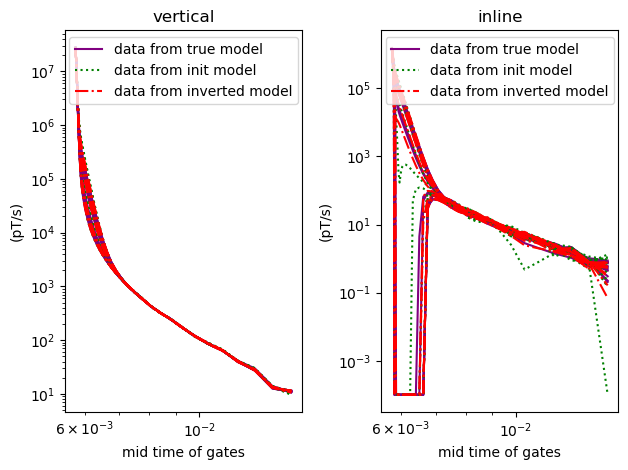

In [13]:
_, (ax1, ax2) = plt.subplots(1, 2)
plot_data(true_param_value, forward, "data from true model", ax1, ax2, color="purple")
plot_data(init_param_value, forward, "data from init model", ax1, ax2, color="green", linestyle=":")
plot_data(my_result.model, forward, "data from inverted model", ax1, ax2, color="red", linestyle="-.")
ax1.legend(loc="upper center")
ax2.legend(loc="upper center")
ax1.set_title("vertical")
ax2.set_title("inline")
plt.tight_layout()

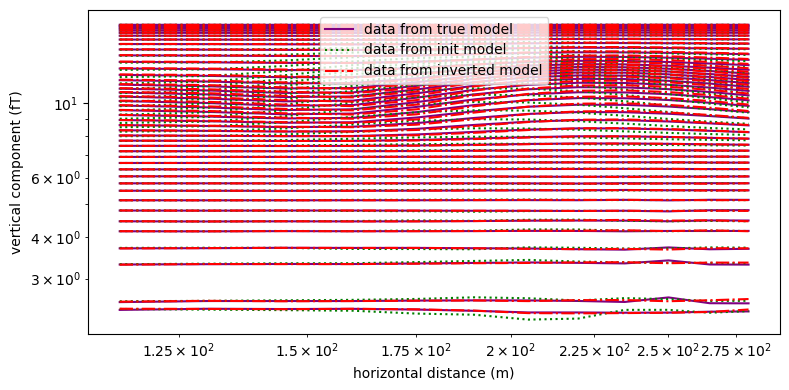

In [14]:
_, ax = plt.subplots(1, 1, figsize=(8,4))
plot_vertical_vs_horizontal_distance(true_param_value, forward, "data from true model", ax, color="purple")
plot_vertical_vs_horizontal_distance(init_param_value, forward, "data from init model", ax, color="green", linestyle=":")
plot_vertical_vs_horizontal_distance(my_result.model, forward, "data from inverted model", ax, color="red", linestyle="-.")
ax.legend(loc="upper center")
plt.tight_layout()

**Plotting the model**

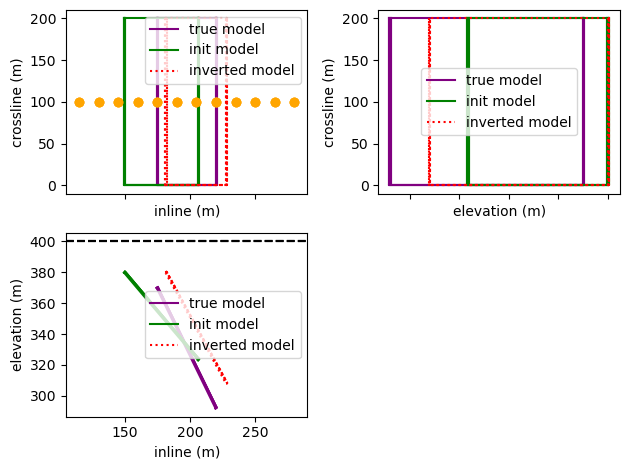

In [15]:
_, axes = plt.subplots(2, 2, sharex="col")
axes[1,1].axis("off")
plot_plate_faces(
    "plate_true", forward, true_param_value, 
    axes[0,0], axes[0,1], axes[1,0], color="purple", label="true model"
)
plot_plate_faces(
    "plate_init", forward, init_param_value, 
    axes[0,0], axes[0,1], axes[1,0], color="green", label="init model"
)
plot_plate_faces(
    "plate_inverted", forward, my_result.model, 
    axes[0,0], axes[0,1], axes[1,0], color="red", label="inverted model", linestyle="dotted"
)
axes[0,0].legend()
axes[0,1].legend()
axes[1,0].legend()
plt.tight_layout()

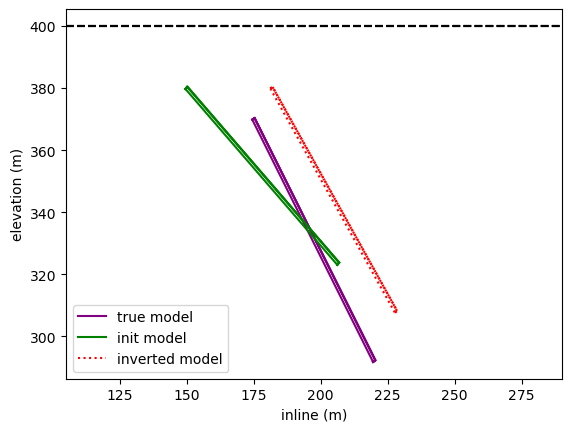

In [16]:
_, ax = plt.subplots(1, 1)
plot_plate_faces_single("plate_true", "xz", forward, true_param_value, ax, color="purple", label="true model")
plot_plate_faces_single("plate_init", "xz", forward, init_param_value, ax, color="green", label="init model")
plot_plate_faces_single("plate_inverted", "xz", forward, my_result.model, ax, color="red", label="inverted model", linestyle="dotted")
ax.legend();

---
## Watermark

<!-- Feel free to add more modules in the watermark_list below, if more packages are used -->
<!-- Otherwise please leave the below code cell unchanged -->

In [17]:
watermark_list = ["cofi", "numpy", "scipy", "matplotlib"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.8
numpy 1.26.4
scipy 1.13.1
matplotlib 3.8.4
